# Marathi2Vec Language Modeling

Thanks to NirantK and cstorm125 for the works Hindi2Vec and Thai2Vec, both of which helped me make this notebook. 

The goal of this notebook is to train Marathi word embeddings using the fast.ai version of AWD LSTM with dropouts, the data was fulled from Wikipedia.

A perplexity of was achieved, there has been no comparable research work in Marathi Language at the point of writing. (2nd October, 2018)


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import dill as pickle
import json 
import re

from IPython.display import Image
from IPython.core.display import HTML

import torchtext
from torchtext import vocab
from torchtext import data as d
from torchtext.datasets import language_modeling

In [4]:
from fastai.learner import *
from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

In [13]:

!cd Data


Data  LICENSE  Marathi2Vec.ipynb  README.md


 - Download or clone WikiExtractor from github
 - To run on windows look at [this](https://github.com/attardi/wikiextractor/issues/89#issuecomment-272062219).
 
 Run the following command :
 
 ```python WikiExtractor.py mrwiki-latest-pages-articles.xml -o extract -b 10M --ignored_tags abbr,b,big --discard_elements gallery,timeline,noinclude```

In [6]:
data = 'Data/'
extract= f'{data}extract/'
train_set = f'{data}train/'
valid_set = f'{data}valid/'
models = f'{data}models/'


In [20]:
%%time
%%prun



ext =  !ls {extract}

def cleanFile(extracted_filelist, dest):    
    cleaned_all = []
    for ext_file in extracted_filelist:
        input_file = f'{extract}{ext_file}'
        with open(input_file,'r', encoding='utf-8') as f:
            raw_txt = f.readlines()
            cleaned_doc = []
            for line in raw_txt:
                new_line = re.sub('<[^<]+?>', '', line)
                new_line = re.sub('__[^<]+?__', '', new_line) 
                new_line = new_line.strip()
                if new_line != '':
                    cleaned_doc.append(new_line)

            new_doc = "\n".join(cleaned_doc)
            cleaned_all.append(new_doc)
            with open(f"{dest}{ext_file}.txt", "w", encoding='utf-8') as text_file:
                text_file.write(new_doc)
    return cleaned_all

cleaned_all = cleanFile(ext, train_set)



 CPU times: user 3.48 s, sys: 164 ms, total: 3.64 s
Wall time: 3.69 s


## Create Validation Set

In [4]:
import random
random.seed(782)

training_files = !ls {train_set}
validation_files = !ls {valid_set} 
split = int(0.2 * len(training_files)) #Doing a 80-20 split
random.shuffle(training_files)
validation_files = training_files[:split]
training_files = training_files[split:]

print(validation_files)
print(training_files)

['wiki_00.txt', 'wiki_06.txt']
['wiki_09.txt', 'wiki_07.txt', 'wiki_03.txt', 'wiki_02.txt', 'wiki_08.txt', 'wiki_05.txt', 'wiki_04.txt', 'wiki_01.txt']


In [5]:
import shutil, os
for root, dirs, files in os.walk(train_set):
     for file in files:
         if file.endswith(".txt") & (file in validation_files):
             shutil.move(os.path.join(root, file),valid_set)
trn_files = !ls {train_set}
val_files = !ls {valid_set}
print(trn_files), print(val_files), print(len(trn_files)), print(len(val_files))

['wiki_01.txt', 'wiki_02.txt', 'wiki_03.txt', 'wiki_04.txt', 'wiki_05.txt', 'wiki_07.txt', 'wiki_08.txt', 'wiki_09.txt']
['wiki_00.txt', 'wiki_06.txt']
8
2


(None, None, None, None)

# Text Processing

There aren't any known Marathi Stemmers available in Python, So i've written these porting taking inspiration from Spacy's hindi tokenizer and stemmer, Since Marathi and Hindi Inherently come from the same script i.e Devanagri.

In [7]:
 from cltk.tokenize.sentence import TokenizeSentence

In [8]:
def word_tokenize(document):
    tokenizer = TokenizeSentence('marathi')
    return tokenizer.tokenize(document)
    
def docs_tokenize(documents_as_lists):   
    for document in documents_as_lists:
        tokens = word_tokenize(document)
        tokens_list.extend(tokens)
    
    return tokens_list

In [7]:
%%time
tokens_filename = "tokens_list.txt"
tokens_list = []

#TODO refactor from try except blocks to if else with if statement checking if file exists using Pathlib

try:
    print(f'Reading from {tokens_filename}')
    with open(tokens_filename, "r") as f:
         tokens_list = json.load(f)
    
except FileNotFoundError:
    print(f'FileNotFound. Trying to tokenize from cleaned_all')
    tokens_list = docs_tokenize(cleaned_all)
    
    with open('tokens_list.txt', 'w') as outfile:
        json.dump(tokens_list, outfile)

print(f'Found {len(tokens_list)} tokens')

Reading from tokens_list.txt
Found 6307733 tokens
CPU times: user 4.4 s, sys: 268 ms, total: 4.67 s
Wall time: 4.69 s


In [9]:
assert torch.cuda.is_available()
#assert torch.backends.cudnn .cudnn.is_available()
#print(torch.backends.cudnn.is_acceptable(torch.cuda.FloatTensor(1)))
#print(torch.backends.cudnn.version())
#print(torch.backends.cudnn.version())
#assert torch.backends.cudnn.enabled()

In [23]:
TEXT = d.Field(lower=True, tokenize=word_tokenize)
#batch size
bs=16
#backprop through time
bptt=70
test_set = f'{data}test/'

In [10]:
FILES = dict(train=f'{train_set}', validation=f'{valid_set}', test=f'{test_set}')

In [25]:
%%time
md = LanguageModelData.from_text_files('', TEXT, **FILES, bs=bs, bptt=bptt, min_freq=50)

CPU times: user 30 s, sys: 1.17 s, total: 31.2 s
Wall time: 31.5 s


In [15]:
%%time
pickle.dump(TEXT, open(f'{data}//models//TEXT_min_freq50.pkl','wb'))

CPU times: user 447 ms, sys: 19.6 ms, total: 467 ms
Wall time: 466 ms


In [16]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(5695, 10883, 1, 6379809)

In [17]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '.', ',', 'आहे', '-', ')', 'या', 'आणि', '(', 'व', 'हे']

In [20]:
TEXT.vocab.stoi['आ']

2449

In [21]:
md.trn_ds[0].text[:12]

['पायरट्स',
 'ऑफ',
 'द',
 'कॅरिबियन',
 '-',
 'अॅट',
 'वर्ल्ड्स',
 'एंड',
 '(',
 'चित्रपट',
 ')',
 'पायरट्स']

In [22]:
next(iter(md.trn_dl))

(tensor([[   0,    0,    2,  ...,   21,    0, 1141],
         [ 182,  739,  315,  ..., 5105,   41, 6403],
         [ 265,    0, 4817,  ...,  217, 8074,   11],
         ...,
         [ 118,    0, 3121,  ...,  173,   11,    4],
         [   2,   61,   18,  ..., 4224,  383,    2],
         [1354,    0,    2,  ...,   21,    0, 5834]], device='cuda:0'),
 tensor([ 182,  739,  315,  ...,  378,   60, 4220], device='cuda:0'))

In [17]:
#trn_ds is list; one for each txt file
txt = md.trn_ds[0].text[:10]
TEXT.numericalize([txt])

tensor([[   0],
        [ 182],
        [ 265],
        [4577],
        [   5],
        [   0],
        [   0],
        [   0],
        [   9],
        [ 107]], device='cuda:0')

In [12]:
em_sz = 300  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [13]:


opt_fn = partial(optim.Adam, betas=(0.7, 0.99))



In [14]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

 77%|███████▋  | 4390/5695 [19:32<05:48,  3.75it/s, loss=19]  

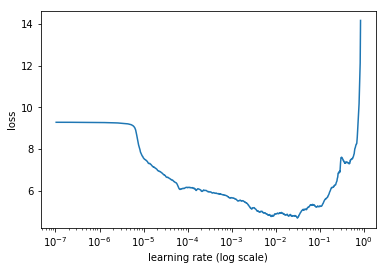

In [15]:
#find suitable learning rates
learner.lr_find(1e-07,1e2)

learner.sched.plot()

In [16]:
learner.fit(1e-4, 4, wds=1e-6, cycle_len=1, cycle_mult=2)
learner.save_encoder('adam1_enc')

epoch      trn_loss   val_loss                                
    0      5.477827   5.596106  
 73%|███████▎  | 4160/5695 [18:54<06:58,  3.67it/s, loss=4.87]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    1      5.045255   5.181519                                
 14%|█▍        | 795/5695 [03:36<22:17,  3.66it/s, loss=5.07]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 55%|█████▌    | 3141/5695 [14:16<11:36,  3.67it/s, loss=4.94]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 95%|█████████▍| 5389/5695 [24:34<01:23,  3.66it/s, loss=4.92]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 32%|███▏      | 1837/5695 [08:06<17:02,  3.77it/s, loss=4.89]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 73%|███████▎  | 4175/5695 [18:24<06:42,  3.78it/s, loss=4.47]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    3      4.70627    4.850859                                
    4      4.589127   4.694453                                
 58%|█████▊    | 3323/5695 [15:01<10:43,  3.69it/s, loss=4.51]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 95%|█████████▌| 5420/5695 [24:28<01:14,  3.69it/s, loss=4.45]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 36%|███▌      | 2055/5695 [09:06<16:07,  3.76it/s, loss=4.6] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 73%|███████▎  | 4161/5695 [18:23<06:46,  3.77it/s, loss=4.2] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    6      4.457709   4.598827                                
 11%|█▏        | 652/5695 [02:52<22:12,  3.78it/s, loss=4.53]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    7      4.386027   4.5027                                  
    8      4.263231   4.391432                                
    9      4.193189   4.313699                                
    10     4.176238   4.256015                                
    11     4.174038   4.217817                                
100%|█████████▉| 5671/5695 [25:02<00:06,  3.77it/s, loss=4.06]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 37%|███▋      | 2128/5695 [09:38<16:09,  3.68it/s, loss=4.15]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 77%|███████▋  | 4370/5695 [19:46<05:59,  3.68it/s, loss=4.12]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    14     4.13349    4.179739                                


In [17]:
learner.save_encoder('mar_adam_enc1')

In [ ]:
learner.fit(1e-3, 1, wds=1e-6, cycle_len=20, cycle_save_name='adam3_20 

epoch      trn_loss   val_loss                                
    0      4.11519    4.177755  
    1      3.874369   4.019278                                
    2      3.746939   3.849714                                
 63%|██████▎   | 3582/5695 [16:20<09:38,  3.65it/s, loss=3.77]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    3      3.669387   3.745317                                
  3%|▎         | 171/5695 [00:48<26:18,  3.50it/s, loss=3.82]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 40%|████      | 2284/5695 [10:53<16:16,  3.49it/s, loss=3.84]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 79%|███████▊  | 4475/5695 [21:24<05:50,  3.48it/s, loss=3.81]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    4      3.615256   3.674289                                
 18%|█▊        | 1009/5695 [04:27<20:43,  3.77it/s, loss=3.44]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 59%|█████▉    | 3348/5695 [14:49<10:23,  3.76it/s, loss=3.63]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 98%|█████████▊| 5554/5695 [24:32<00:37,  3.77it/s, loss=3.5] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 36%|███▌      | 2060/5695 [09:17<16:24,  3.69it/s, loss=3.68]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 75%|███████▌  | 4285/5695 [19:20<06:21,  3.69it/s, loss=3.53]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    6      3.596615   3.584729                                
 15%|█▍        | 851/5695 [03:50<21:53,  3.69it/s, loss=3.62]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 53%|█████▎    | 3035/5695 [13:40<11:58,  3.70it/s, loss=3.62]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 91%|█████████ | 5178/5695 [23:20<02:19,  3.70it/s, loss=3.55]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 31%|███       | 1737/5695 [07:51<17:54,  3.68it/s, loss=3.51]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 66%|██████▌   | 3757/5695 [17:00<08:46,  3.68it/s, loss=3.3] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    8      3.488636   3.509863                                
  3%|▎         | 198/5695 [00:51<23:50,  3.84it/s, loss=3.66]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    9      3.486521   3.483568                                
    10     3.508965   3.459164                                
    11     3.425149   3.422537                                
 72%|███████▏  | 4086/5695 [18:10<07:09,  3.75it/s, loss=3.37]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 10%|▉         | 564/5695 [02:34<23:24,  3.65it/s, loss=3.55]

In [19]:
learner.fit(1e-3, 1, wds=1e-6, cycle_len=5, cycle_save_name='adam3_20')

epoch      trn_loss   val_loss                                
    0      3.547923   3.511553  
    1      3.446109   3.449121                                
    2      3.436924   3.388949                                
    3      3.338178   3.331549                                
    4      3.37434    3.309025                                


[array([3.30903])]

In [20]:
learner.save_encoder('mar_adam3_20')



In [21]:
m=learner.model

In [28]:
ss="""सुनीतिने पुत्र ध्रुवाला म्हणाली की श्रीविष्णूची उपासना कर,तो जगतपालक पिता आहे. परमात्मा श्रीविष्णूनारायणच्या मांडीवर बसायचे असेल तर बस. नन्तर तो ध्रुव पाच वयापासून राजवाड्या सोडून गेला,अशा प्रकारे बालक ध्रुव यमुना नदीच्या किनारावर पोहचला मग तो यमुना नदीत स्नान करत होता त्या मर्गात देवऋषि नारद भेटतो.देवऋषि नारदांनी ध्रुवाला सांगितले की घरी परत जावे, परंतु ध्रुवाला विश्वास नव्हता, तर नारदांनी ध्रुवाला ओम् नमो भगवते वासुदेवाय या मंत्राची दीक्षा दिली .देवऋषि नारद तिथून निघून गेला. आणि तपश्चर्येची सुरुवात झाली. एका पायावर उभे राहून सहा महिने कठोर तपस्या  केले. ॐ नमो भगवते वासुदेवाय मन्त्र ध्वनि वैकुंठ पर्यत पोहचले."""
s = [word_tokenize(ss)]
t = TEXT.numericalize(s)

In [29]:
t


Variable containing:
     0
   672
     0
     0
    91
     0
  4316
  1506
     3
    63
     0
  4454
     4
     2
     0
     0
     0
     0
   406
    37
   758
     2
     0
  7715
   345
     0
     0
   861
   242
     3
    88
   815
  7726
  7715
  5261
   533
     0
     0
   610
    63
  5261
  5869
  4125
   249
    28
    42
     0
     0
 10263
     0
     2
     0
     0
     0
   518
    91
  1164
   505
  1564
     3
   155
     0
  1435
  1538
     3
    37
     0
     0
     0
     0
     0
     0
     7
     0
  3962
     0
     2
     0
 10263
  4452
  2765
   242
     2
     8
     0
   281
    66
     2
    84
     0
  1031
  1727
   546
  1462
  4483
     0
    26
     2
  8357
     0
     0
     0
     0
     0
     0
     0
     2
[torch.cuda.LongTensor of size 107x1 (GPU 0)]

In [30]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res, *other_things = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [31]:


other_things



[[Variable containing:
  ( 0 ,.,.) = 
    3.8011e-02 -2.2014e-02  7.8308e-02  ...  -1.6953e-02  4.8350e-02 -4.5729e-03
  
  ( 1 ,.,.) = 
    3.0540e-02  2.4192e-01 -6.9744e-03  ...  -6.5229e-01 -2.2948e-01  4.1202e-01
  
  ( 2 ,.,.) = 
    1.7917e-01  2.3620e-01  3.5599e-01  ...  -6.2822e-03  4.9435e-02 -7.2944e-04
  ... 
  
  (104,.,.) = 
    1.1183e-01 -1.7880e-02  1.7792e-01  ...  -8.4721e-03  1.7791e-02 -3.8099e-03
  
  (105,.,.) = 
    1.1294e-01 -1.5163e-02  1.9261e-01  ...  -1.4744e-03  1.7169e-02 -3.7645e-03
  
  (106,.,.) = 
    3.7854e-03  4.2614e-03  1.8565e-01  ...  -4.1853e-03  1.8322e-03 -6.5098e-03
  [torch.cuda.FloatTensor of size 107x1x500 (GPU 0)], Variable containing:
  ( 0 ,.,.) = 
   -1.3693e-02  1.2531e-02 -2.9094e-03  ...   8.3595e-02 -9.4321e-03  4.7299e-02
  
  ( 1 ,.,.) = 
    5.8883e-02 -8.9473e-02 -2.0179e-02  ...   1.7967e-02 -6.9051e-02 -6.5057e-02
  
  ( 2 ,.,.) = 
    2.5043e-01 -3.5599e-02  4.0335e-02  ...   6.7441e-02 -2.5366e-02  3.1976e-01
  ... 
  


In [32]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['<unk>', 'त्या', 'या', 'तेव्हा', 'पण', 'तो', 'आणि', 'परंतु', '.', 'ते']

In [33]:
print(ss,"\n")
for i in range(100):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

सुनीतिने पुत्र ध्रुवाला म्हणाली की श्रीविष्णूची उपासना कर,तो जगतपालक पिता आहे. परमात्मा श्रीविष्णूनारायणच्या मांडीवर बसायचे असेल तर बस. नन्तर तो ध्रुव पाच वयापासून राजवाड्या सोडून गेला,अशा प्रकारे बालक ध्रुव यमुना नदीच्या किनारावर पोहचला मग तो यमुना नदीत स्नान करत होता त्या मर्गात देवऋषि नारद भेटतो.देवऋषि नारदांनी ध्रुवाला सांगितले की घरी परत जावे, परंतु ध्रुवाला विश्वास नव्हता, तर नारदांनी ध्रुवाला ओम् नमो भगवते वासुदेवाय या मंत्राची दीक्षा दिली .देवऋषि नारद तिथून निघून गेला. आणि तपश्चर्येची सुरुवात झाली. एका पायावर उभे राहून सहा महिने कठोर तपस्या  केले. ॐ नमो भगवते वासुदेवाय मन्त्र ध्वनि वैकुंठ पर्यत पोहचले. 

त्या वेळी त्या त्या वेळी त्या त्या वेळी त्या त्या वेळी त्या त्या वेळी त्या त्या त्या त्या त्या त्या त्या त्या त्या त्या त्या त्या त्या त्या त्या त्या त्या त्या त्या ठिकाणी त्या त्या त्या त्या त्या त्या ठिकाणी त्या त्या त्या त्या त्या त्या ठिकाणी त्या त्या त्या त्या त्या त्या त्या ठिकाणी त्या त्या त्या त्या त्या त्या त्या त्या ठिकाणी त्या त्या त्या त्या त्या त्या त्या त्या ठिकाण

In [36]:
#TEXT = pickle.load(open(f'{data}models/TEXT.pkl','rb'))
m = pickle.load(open(f'{data}models/wiki_lang.pkl','rb'))
m[0].bs=1
m.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'Data/models/wiki_lang.pkl'

In [39]:
m = learner.model
pickle.dump(m,open(f'{data}models/wiki_lang.pkl','wb'))

In [47]:
def gen_text(ss,topk):
    s = [word_tokenize(ss)]
    t = TEXT.numericalize(s)
    m.reset()
    pred,*_ = m(t)
    pred_i = torch.topk(pred[-1], topk)[1]
    return [TEXT.vocab.itos[o] for o in to_np(pred_i)]


def gen_sentences(ss,nb_words):
    result = []
    s = [word_tokenize(ss)]
    t = TEXT.numericalize(s)
    m.reset()
    pred,*_ = m(t)
    for i in range(nb_words):
        pred_i = pred[-1].topk(2)[1]
        pred_i = pred_i[1] if pred_i.data[0] < 2 else pred_i[0]
        result.append(TEXT.vocab.itos[pred_i.data[0]])
        pred,*_ = m(pred_i[0].unsqueeze(0))
    return(result)

In [48]:
ss = 'मांडीवरुन'
gen_text(ss,10)

['<unk>', ',', '(', '.', '-', 'आणि', 'व', 'या', 'हे', 'एक']

In [49]:
''.join(gen_sentences(ss,50))

',आणिइतरअनेकठिकाणी,तसेच,काहीठिकाणी,आणिकाहीठिकाणी,आणिकाहीठिकाणी,आणिकाहीठिकाणी,आणिकाहीठिकाणी,आणिकाहीठिकाणी,आणिकाहीठिकाणी,आणिकाहीठिकाणी,आणिकाहीठिकाणी,आणिकाहीठिकाणी,आणिकाहीठिकाणी'

In [50]:
emb_weights = list(learner.model.named_parameters())[0][1]
emb_np = to_np(emb_weights.data)

In [51]:
emb_np.shape

(10883, 300)

In [53]:
TEXT = pickle.load(open(f'{data}//models//TEXT_min_freq50.pkl','rb'))

In [59]:
TEXT.vocab.set_vectors(vectors=emb_weights.data,dim=300,stoi=TEXT.vocab.stoi)
pickle.dump(TEXT, open(f'{data}models/TEXT_vec.pkl','wb'))

In [60]:
TEXT_vec = pickle.load(open(f'{data}models/TEXT_vec.pkl','rb'))


In [64]:
Marathi2Vec = pd.DataFrame(to_np(TEXT_vec.vocab.vectors))
Marathi2Vec.index = TEXT_vec.vocab.itos
Marathi2Vec.head(10)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
<unk>,0.184997,0.264473,-0.097014,-0.290698,1.087013,-0.012152,-0.130357,-0.075503,-1.033792,-0.094126,...,-0.188687,0.614073,0.030553,0.120845,-0.069144,0.575417,0.073500,-0.102559,-0.020888,0.096940
<pad>,1.111438,-0.647768,-0.130779,0.539828,-0.731522,-0.184220,0.017115,-0.267929,0.771284,0.171368,...,-0.130344,-0.858178,0.127670,0.048101,-0.486750,-0.391033,0.369913,0.223407,0.014221,-0.127747
.,0.507393,-0.548240,-0.233227,0.365200,0.163352,-0.169116,0.243545,0.058599,-0.830403,0.296732,...,0.331643,0.385975,0.191352,0.014524,-0.071620,-0.131696,0.533716,-0.107223,0.304124,-0.314744
",",0.144995,0.153567,0.023297,1.201630,0.204971,-0.058352,0.322609,-0.045884,-0.394390,0.102550,...,0.421565,0.524912,0.004927,-0.061385,0.005321,0.326663,0.297671,0.025799,-0.226861,-0.054824
आहे,0.735788,-0.691541,-0.172692,0.698590,0.261332,-0.262978,0.329193,0.069133,-0.301735,0.042741,...,-0.292696,0.116984,-0.042562,0.255620,-0.374256,-0.051591,0.584917,-0.022902,0.311255,0.051013
-,0.195843,0.212652,-0.080147,0.244377,-0.114356,-0.089846,0.242360,-0.397300,0.961301,-0.160332,...,-0.255346,0.282573,0.034157,-0.017026,-0.274331,-1.616143,0.260197,0.043800,-0.302228,-0.440643
),1.403893,-0.514077,0.012261,1.457787,-0.698837,-0.402772,-0.254091,0.013123,1.874941,-0.323439,...,0.586915,0.284783,0.187276,-0.093994,-0.470145,-0.256428,1.117356,0.164209,-0.183921,-0.245569
या,-0.060040,-0.128077,-0.017541,-0.108856,0.048029,-0.484692,0.241262,-0.030532,0.610970,0.146330,...,-0.106549,-0.188705,0.215217,-0.236082,-0.635500,-0.439362,-0.045556,-0.099556,0.223018,-0.067861
आणि,0.368652,-0.100921,0.012451,0.901033,0.224826,-0.142603,-0.001697,-0.163967,0.219325,-0.077335,...,-0.066042,0.303783,0.004747,-0.056713,-0.121099,-0.698943,0.222724,-0.023987,-0.195869,-0.152897
(,0.346725,0.304007,-0.141699,1.099876,-0.483198,0.322204,-0.076687,0.007891,-0.738378,0.036106,...,-0.173015,0.010330,0.168522,-0.056741,-0.155863,-0.338089,-0.244678,-0.123678,0.191682,-0.708546


In [65]:
Marathi2save = Marathi2Vec[~hindi2vec.index.str.contains(' ')]

Marathi2save.to_csv(f'{data}models//Marathi2Vec.vec',sep=' ',header=False, line_terminator='\n')
#add NB_ROWS NB_COLS as header
Marathi2save.shape

(10883, 300)